In [1]:
#%%writefile test.py
import pandas as pd
import numpy as np
import cv2
import os
import re
import albumentations as A
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from PIL import Image
from albumentations.pytorch.transforms import ToTensorV2
from matplotlib import pyplot as plt
from tqdm import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DIR_INPUT = '../input/rsna-pneumonia-detection-2018/input/images'
df = pd.read_csv("../input/rsna-pneumonia-detection-2018/input/stage_2_train_labels.csv")
#print(df.shape)
#df.head()

df_pos = pd.DataFrame(columns=['patientId', 'x', 'y', 'width', 'height'])

k = 0
df.loc[df['patientId']=="00436515-870c-4b36-a041-de91049b9ab4"]
for i in range(len(df)):
    if df.loc[i]['Target'] == 1:
        df_pos.loc[k] = df.loc[i]
        k += 1
image_ids = df_pos['patientId'].unique()
#print(image_ids)
DIR_TEST = "../input/rsna-pneumonia-detection-2018/input/images"
valid_ids = image_ids[-300:]
valid_df = df_pos[df_pos['patientId'].isin(valid_ids)]
print(valid_df.head())
print("****************",valid_df.shape)
test_images = os.listdir(DIR_TEST)
#print(f"Validation instances: {len(valid_ids)}")

# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, min_size=1024)
num_classes = 2  # 1 class (pnueomonia) + background
# get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

os.makedirs('../validation_predictions', exist_ok=True)
model.load_state_dict(torch.load('../input/rsna-pytorch-hackathon-fasterrcnn-resnet-training/fasterrcnn_resnet50_fpn.pth'))
model.to(device)

def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], 
                                                             int(j[1][0]), int(j[1][1]), 
                                                             int(j[1][2]), int(j[1][3])))

    return " ".join(pred_strings)

detection_threshold = 0.9
img_num = 0
results = []
model.eval()
f, ax = plt.subplots(3,3, figsize=(16,18))
img = []
with torch.no_grad():
    for i, image_s in tqdm(enumerate(image_ids)):
        #print(i,image_s)
        if i>100:
            break
        #orig_image = cv2.imread(f"{DIR_TEST}/{test_images[i]}", cv2.IMREAD_COLOR)
        orig_image = cv2.imread(f"{DIR_TEST}/{image_ids[i]}.jpg", cv2.IMREAD_COLOR)
        image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = np.transpose(image, (2, 0, 1)).astype(np.float)
        image = torch.tensor(image, dtype=torch.float).cuda()
        image = torch.unsqueeze(image, 0)

        model.eval()
        cpu_device = torch.device("cpu")

        outputs = model(image)
        
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        #print(outputs)
        if len(outputs[0]['boxes']) != 0:
            for counter in range(len(outputs[0]['boxes'])):
                boxes = outputs[0]['boxes'].data.cpu().numpy()
                scores = outputs[0]['scores'].data.cpu().numpy()
                boxes = boxes[scores >= detection_threshold].astype(np.int32)
                draw_boxes = boxes.copy()
                boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
                
            for box in draw_boxes:
                img=cv2.rectangle(orig_image,
                            (int(box[0]), int(box[1])),
                            (int(box[2]), int(box[3])),
                            (0, 0, 255), 3)

            #print("**********start********")
            plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            
            #plt.savefig(f"./{image}.jpg")
            plt.close()

            result = {
                'patientId': image_s,
                'PredictionString': format_prediction_string(boxes, scores),
                'pred_cls': 1 if len(draw_boxes) >0 else 0,
                'actual_cls': 1,
            }
            results.append(result)
        else:
            result = {
                'patientId': image_s,
                'PredictionString': None,
                'pred_cls': 0,
                'actual_cls': 1,
            }
            results.append(result)

#print(results)
sub_df = pd.DataFrame(results, columns=['patientId', 'PredictionString', 'pred_cls', 'actual_cls'])
print(sub_df)
#sub_df.to_csv('submission.csv', index=False)

                                 patientId      x      y  width  height
9057  0e08846c-ab58-48d1-9919-f5ea1f47d032  710.0  372.0  164.0   322.0
9058  0e08846c-ab58-48d1-9919-f5ea1f47d032  180.0  744.0  242.0    87.0
9059  0e0df6e1-1a66-4122-a14b-7a4cd106421f  144.0  550.0  198.0    70.0
9060  0e4f5b45-1fa4-406b-8ed8-d5ced6374c0d  245.0  518.0  171.0    84.0
9061  0e4f5b45-1fa4-406b-8ed8-d5ced6374c0d  681.0  441.0  122.0   131.0
**************** (498, 5)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


0it [00:00, ?it/s]/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
101it [00:15,  6.45it/s]

                                patientId  \
0    00436515-870c-4b36-a041-de91049b9ab4   
1    00704310-78a8-4b38-8475-49f4573b2dbb   
2    00aecb01-a116-45a2-956c-08d2fa55433f   
3    00c0b293-48e7-4e16-ac76-9269ba535a62   
4    00f08de1-517e-4652-a04f-d1dc9ee48593   
..                                    ...   
96   06d5a58d-baf1-4937-bfc3-00db1fb2b1be   
97   06d6e209-0bd4-45d4-81b4-4b97546d57fa   
98   06df5d57-6f34-43c0-99ad-b9b5f9346cbd   
99   06e09ebb-cb5b-4c30-8d3a-67a6ec34692b   
100  06ec9278-5144-4b88-87f4-c195bb24857d   

                                  PredictionString  pred_cls  actual_cls  
0                                                          0           1  
1                                                          0           1  
2                                                          0           1  
3    0.9761 243 554 204 220 0.9587 652 463 191 308         1           1  
4                                                          0           1  
..       

Accuracy :  0.594059405940594


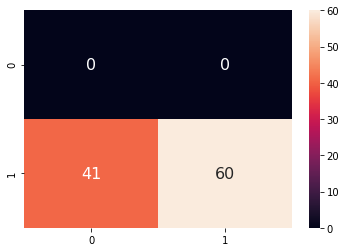

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = confusion_matrix(sub_df['actual_cls'], sub_df['pred_cls'])
tn, fp, fn, tp = confusion_matrix(sub_df['actual_cls'], sub_df['pred_cls']).ravel()
print("Accuracy : ",(tp+fp)/(tn+fp+fn+tp))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.show()

In [3]:
#!python test.py